
🔍 Ortalama Kare Hata (MSE): 0.02391428616698416


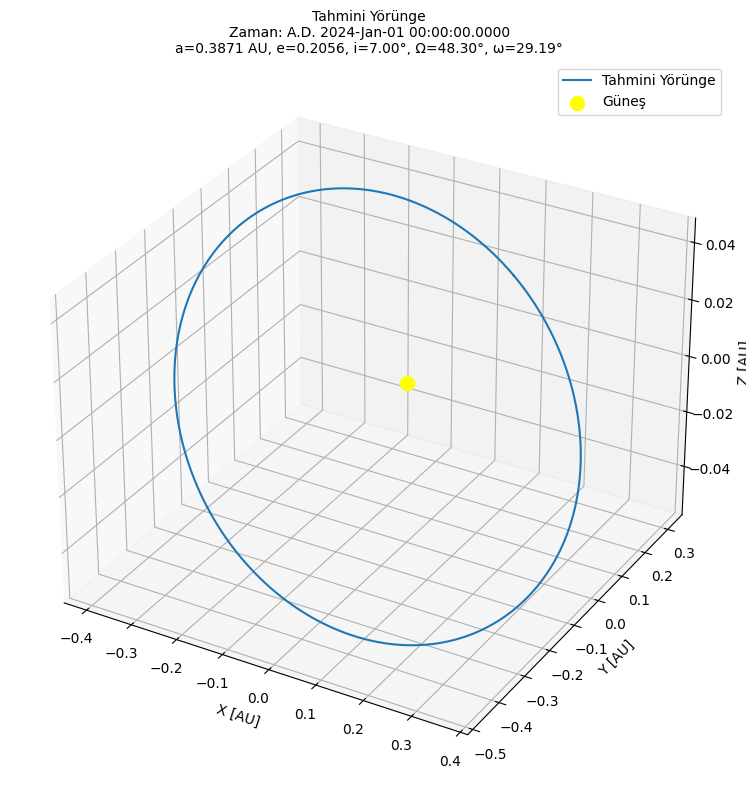


📊 İlk 5 Örnek İçin Kepler Elemanları Karşılaştırması:

   Gerçek a  Tahmin a       Fark a  Gerçek e  Tahmin e       Fark e  Gerçek i  \
0    0.3871    0.3871  1.96634e-08   0.20563   0.20563  4.48773e-08   7.00358   
1    0.3871    0.3871  1.46341e-08   0.20563   0.20563  3.15243e-08   7.00358   
2    0.3871    0.3871  1.36543e-08   0.20563   0.20563  6.18431e-09   7.00358   
3    0.3871    0.3871  4.81312e-09   0.20563   0.20563  2.88777e-08   7.00358   

   Tahmin i       Fark i  Gerçek Ω  Tahmin Ω       Fark Ω  Gerçek ω  Tahmin ω  \
0   7.00358  1.51518e-07  48.30074  48.30074  1.84837e-06  29.19162  29.19149   
1   7.00358  1.86873e-07  48.30073  48.30073  1.66460e-08  29.19287  29.19288   
2   7.00358  9.02455e-08  48.30072  48.30072  7.37014e-08  29.19270  29.19271   
3   7.00358  9.23603e-09  48.30073  48.30073  1.11128e-06  29.19165  29.19159   

        Fark ω  
0  1.31014e-04  
1  1.26459e-05  
2  7.27764e-06  
3  6.40592e-05  


In [2]:
import pandas as pd
import numpy as np
from astroquery.jplhorizons import Horizons
from astropy import units as u
from astropy.time import Time
from poliastro.bodies import Sun
from poliastro.twobody import Orbit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# 1. JPL Horizons API'den veri çek (örnek asteroid: Ceres, ID: 1)
target_id = '1'  # Ceres
epochs = {'start': '2024-01-01', 'stop': '2024-01-20', 'step': '1d'}
obj = Horizons(id=target_id, location='@sun', epochs=epochs, id_type='id')
vectors = obj.vectors()

# 2. Veriyi DataFrame'e aktar
df = vectors.to_pandas()
df_vectors = df[['x', 'y', 'z', 'vx', 'vy', 'vz']].copy()

# 3. Kepler elemanlarını hesapla (etiketler)
kepler_elements = []
valid_indices = []

for i in range(len(df_vectors)):
    try:
        r = df_vectors.loc[i, ['x', 'y', 'z']].values * u.AU
        v = df_vectors.loc[i, ['vx', 'vy', 'vz']].values * (u.AU / u.day)
        epoch = Time(df.loc[i, 'datetime_jd'], format='jd', scale='tdb')
        orb = Orbit.from_vectors(Sun, r, v, epoch)

        kepler_elements.append([
            orb.a.to(u.AU).value,
            orb.ecc.value,
            orb.inc.to(u.deg).value,
            orb.raan.to(u.deg).value,
            orb.argp.to(u.deg).value
        ])
        valid_indices.append(i)
    except Exception as e:
        print(f"Geçersiz satır {i}: {e}")
        continue

# 4. Girdi ve hedef veriler
X = df_vectors.loc[valid_indices].reset_index(drop=True)
y = pd.DataFrame(kepler_elements, columns=['a', 'e', 'i', 'om', 'w'])

# 5. Ölçekleme
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 6. Eğitim/test ayırma ve model eğitimi
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)
model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=2000, random_state=42)
model.fit(X_train, y_train)

# 7. Tahmin ve hata
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\n🔍 Ortalama Kare Hata (MSE):", mse)

# 8. Geri ölçeklendirme
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

# 9. İlk tahmin edilen örneğe ait yörünge bilgisi
sample = y_pred_inv[0]
a, e, inc, raan, argp = sample
epoch = Time.now()

orb_pred = Orbit.from_classical(
    attractor=Sun,
    a=a * u.AU,
    ecc=e * u.one,
    inc=inc * u.deg,
    raan=raan * u.deg,
    argp=argp * u.deg,
    nu=0.0 * u.deg,
    epoch=epoch
)

# 9.1: Tahmin edilen örneğin hangi veri noktasına karşılık geldiğini bul
first_test_vector = X_test[0]
for i, row in enumerate(X_scaled):
    if np.allclose(row, first_test_vector, atol=1e-6):
        original_index = i
        break

# Gözlem zamanını al
datetime_str = df.loc[valid_indices[original_index], 'datetime_str']

# 9.2: Orbiti propagate et (zamanla ilerlet)
times = epoch + np.linspace(0, orb_pred.period.to(u.day).value, 500) * u.day
positions = np.array([orb_pred.propagate(t - epoch).r.to(u.AU).value for t in times])

# 9.3: 3B yörünge çizimi
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label="Tahmini Yörünge")
ax.scatter(0, 0, 0, color='yellow', label='Güneş', s=100)

# Başlık: gözlem zamanı ve tahmin edilen Kepler elemanları
ax.set_title(f"Tahmini Yörünge\nZaman: {datetime_str}\n"
             f"a={a:.4f} AU, e={e:.4f}, i={inc:.2f}°, Ω={raan:.2f}°, ω={argp:.2f}°",
             fontsize=10)

ax.set_xlabel("X [AU]")
ax.set_ylabel("Y [AU]")
ax.set_zlabel("Z [AU]")
ax.legend()
plt.tight_layout()
plt.show()

# 10. Sayısal karşılaştırma tablosu (ilk 5 örnek)
y_true_sample = y_test_inv[:5]
y_pred_sample = y_pred_inv[:5]
kepler_diff = np.abs(y_true_sample - y_pred_sample)

comparison_df = pd.DataFrame({
    'Gerçek a': y_true_sample[:, 0],
    'Tahmin a': y_pred_sample[:, 0],
    'Fark a': kepler_diff[:, 0],
    
    'Gerçek e': y_true_sample[:, 1],
    'Tahmin e': y_pred_sample[:, 1],
    'Fark e': kepler_diff[:, 1],
    
    'Gerçek i': y_true_sample[:, 2],
    'Tahmin i': y_pred_sample[:, 2],
    'Fark i': kepler_diff[:, 2],
    
    'Gerçek Ω': y_true_sample[:, 3],
    'Tahmin Ω': y_pred_sample[:, 3],
    'Fark Ω': kepler_diff[:, 3],
    
    'Gerçek ω': y_true_sample[:, 4],
    'Tahmin ω': y_pred_sample[:, 4],
    'Fark ω': kepler_diff[:, 4],
})

pd.set_option("display.precision", 5)
print("\n📊 İlk 5 Örnek İçin Kepler Elemanları Karşılaştırması:\n")
print(comparison_df)
